# Parallel implementation of bifurcation map

Slightly changed the code to plot bif map after the cycle in comparison to the first task

In [26]:
%%writefile parallel_bif_map.py

#import libs
import numpy as np
from mpi4py import MPI


comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

m = 100
N = 1000
x0 = 0.04
perrank = N // size
# define logistic map equation
def logistic_map(r, x):
    return r * x * (1 - x)

# save m last x
def SaveX(r,x0,m):
    x = np.zeros(N)
    x[0] = x0

    for n in range(1,N):
        x[n] = logistic_map(r, x[n-1])
    return x[-m:]

def bif_map(m, N, x0, rank):
    r_full = np.linspace(0, 4.0, N)
    r = r_full[perrank * rank : perrank * (rank + 1)] #divide r into chunks depending on the rank (current proc number)
    if rank == (size - 1):  #if it the last process, add remained
        r = r_full[perrank * rank:]

    x = np.zeros((len(r),m))

    for i,r_i in enumerate(r):
        x[i,:] = SaveX(r_i,x0,m)
    
    return r, x

start = MPI.Wtime()

r, x = bif_map(m, N, x0, rank)

# gather the result at the master node
r, x = comm.gather(x, root = 0), comm.gather(r, root = 0)

end = MPI.Wtime()

if rank == 0:
    print (end - start)

Overwriting parallel_bif_map.py


In [35]:
import matplotlib.pyplot as plt
import numpy as np
#set params for plot
plt.rcParams["figure.figsize"] = (14,7)
plt.rcParams["font.size"] = 20


In [31]:
exe_time = []
N_processes = np.arange(1,11)
for i in N_processes:
    add = !mpiexec -n {i} python parallel_bif_map.py
    exe_time.append(float(add[0]))


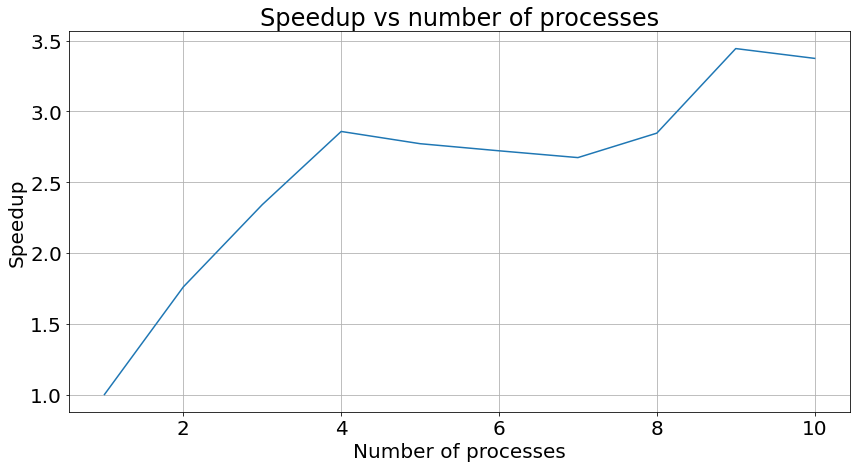

In [36]:
plt.plot(N_processes,  exe_time[0] / np.array(exe_time))
plt.title('Speedup vs number of processes')
plt.xlabel('Number of processes')
plt.ylabel('Speedup')
plt.grid(True)